# Clustering drone hubs

## Assignment understanding

This assignment is based on a real-world drone delivery scenario. We've used Amazon's drone delivery system as an inspirational prototype for the machine learning problem we aim to solve. However, it's important to note that our dataset is completely independent of Amazon

With this assignment we aim to address two theoretical problem:

1. **Minimize Delivery Times & Costs**: By strategically placing drone hubs (depots), the company can reduce the average travel distance for each delivery, leading to lower energy costs and faster service. We will use **k-means and hierarchical clustering** to determine the optimal coordinates for these hubs.

2. **Increase Sales Revenue**: By understanding customer purchasing patterns, the company can create targeted marketing campaigns and product bundles. We will identify which product groups are frequently bought together using **Association Rule Mining**, as discussed in our lectures.

In [54]:
# --- Necessary Setup For This Assignment ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from time import perf_counter

from sklearn.cluster import KMeans, AgglomerativeClustering

# Set plot style for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Data understanding

This assignment uses two distinct datasets, one for each part of the analysis. Both have been imported from the GitHub repository provided by our instructor.

### 1. Clustering dataset

In [55]:
# Load the customer location data
locations_df = pd.read_csv('./droneData/drone_cust_locations.csv ', sep=';')

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the dataset: ---\n")
display(locations_df.head(5))


# Display the all relevant info in a transposed summary table
print("\n--- Summary Table --- \n")
# Get descriptive statistics and transpose it
summary_table = locations_df.describe().T

# Add columns for data type and missing values
summary_table['value_type'] = locations_df.dtypes
summary_table['missing_values'] = locations_df.isnull().sum()

display(summary_table)


--- First 5 rows of the dataset: ---



,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298



--- Summary Table --- 



,count,mean,std,min,25%,50%,75%,max,value_type,missing_values
clientid,5956.0,2978.500000,1719.493433,1.000000,1489.750000,2978.500000,4467.250000,5956.000000,int64,0
x,5956.0,508.823177,271.061462,0.017692,282.582920,518.100892,727.156497,999.533215,float64,0
y,5956.0,427.554772,289.044640,0.043285,170.079921,397.786441,669.982518,999.731720,float64,0


The customer locations dataset contains 5,956 entries and three initial features. The data is clean, with no missing values found.

Here's a breakdown of the columns:

- `clientid`: This is an integer column that uniquely identifies each customer. It will be excluded from the clustering model, as it's an identifier and not a geographic feature.

- `x` and `y`: These are float columns representing the customers' geographic coordinates. They are the essential features for our analysis. Their values range from 0 to 1000.

### 2. Association dataset

In [56]:
# Load the product group data
products_df = pd.read_csv('./droneData/drone_prod_groups.csv')

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the product dataset: ---\n")
display(products_df.head(5))


# Display the all relevant info in a transposed summary table
print("\n--- Product Data Summary Table --- \n")

# Create a DataFrame from the column names
features_summary_df = pd.DataFrame(products_df.columns, columns=['Feature'])

# Add columns for Data Type, Missing Values, and a list of Unique Values
features_summary_df['Data Type'] = products_df.dtypes.values
features_summary_df['Value Count'] = products_df.count().values
features_summary_df['Missing Values'] = products_df.isnull().sum().values
features_summary_df['Unique Values'] = [', '.join(map(str, products_df[col].unique())) for col in products_df.columns]

# Set the 'Feature' column as the index for cleaner presentation
features_summary_df.set_index('Feature', inplace=True)

display(features_summary_df)


--- First 5 rows of the product dataset: ---



,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1



--- Product Data Summary Table --- 



,Data Type,Value Count,Missing Values,Unique Values
Feature,,,,
ID,int64,100000,0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,..."
Prod1,int64,100000,0,"0, 1"
Prod2,int64,100000,0,"0, 1"
Prod3,int64,100000,0,"0, 1"
Prod4,int64,100000,0,"0, 1"
Prod5,int64,100000,0,"0, 1"
Prod6,int64,100000,0,"0, 1"
Prod7,int64,100000,0,"0, 1"
Prod8,int64,100000,0,"0, 1"


The customer transactions dataset contains 100,000 entries and 21 initial features. The data is clean, with no missing values found.

Here's a breakdown of the columns:

- `ID`: An integer that uniquely identifies each transaction. It will be excluded from the analysis.

- from `prod1` to `prod20`: These are binary columns, each representing a unique product group. The value is `1` if an item from that group was purchased in the transaction and `0` if it was not.


## Data preparation

For this assignment, the datasets are quite clean and well-structured.

- For clustering, we will use the `x` and `y` columns from `locations_df` directly.

- For association rule mining, we will use the product columns (`Prod1` to `Prod20`) from `products_df`. The `ID` column will be dropped as it is not a feature.

In [57]:
# Prepare data for clustering
X_locations = locations_df[['x', 'y']]

# Prepare data for association rule mining
# Drop the transaction ID column
X_products = products_df.drop('ID', axis=1).astype(bool)


## Part 1: Finding optimal hub locations


#### 1) Initial Visualization of Customer Locations

Our first goal is to identify the best locations for the drone delivery hubs. We will start by visualizing the customer locations to understand their distribution.


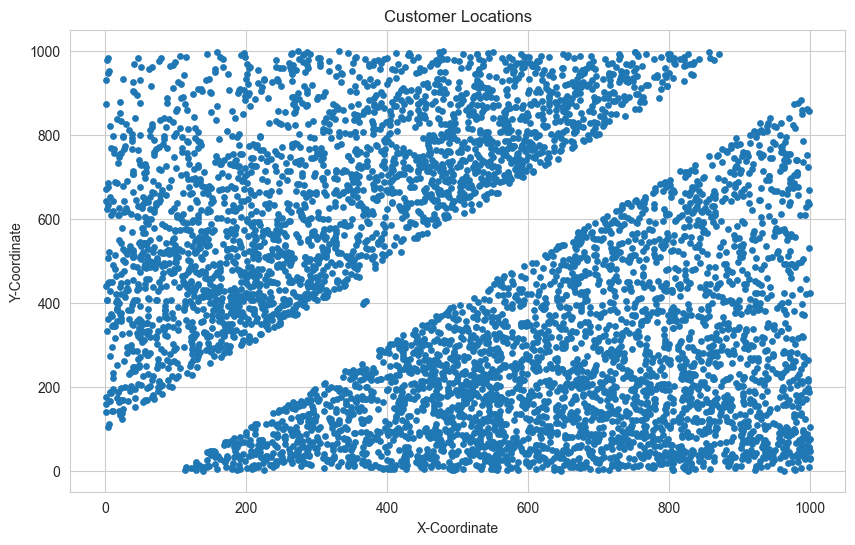

In [58]:
# Create a scatterplot of client locations
plt.figure()
plt.scatter(X_locations["x"], X_locations["y"], s=15)  # ei määritetä värejä -> oletus
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.title("Customer Locations")
plt.show()

The scatter plot reveals two distinct clusters of customers separated by a diagonal empty strip. This pattern suggests the customer base is not evenly distributed. A plausible geographic interpretation could be that this empty space represents a natural barrier, like a river, with the few isolated points possibly indicating customers on an island.

Given this uneven distribution, a strategic placement of hubs in the center of these dense areas would be far more efficient than random placement. However, manually identifying the best hub locations would be difficult, especially considering the triangular shape of the clusters and the varying densities within them. This visual evidence strongly supports using a clustering algorithm to find the optimal hub locations mathematically.


#### 2) K-Means Clustering (3 Depots)



In [59]:
n_depots = 3  # haluttu depottien määrä

kmeans = KMeans(init="random", n_clusters=n_depots, random_state=42)
kmeans.fit(X_locations[["x", "y"]])
labels = kmeans.labels_ 

centroids = kmeans.cluster_centers_  # alueiden keskipisteiden (tässä yhteydessä depottien) sijainnit

print(f"K-means: {n_depots} depotia")
print("Depotien (centroidien) sijainnit:\n", pd.DataFrame(centroids, columns=["x", "y"]))


K-means: 3 depotia
Depotien (centroidien) sijainnit:
             x           y
0  702.081092  211.270383
1  198.440989  383.258618
2  548.205865  787.278896



#### 3) Lähimmän depotin lisääminen dataan


In [60]:
df_kmeans = X_locations.copy() # luodaan uusi dataframe jossa jokaisella asiakkaalle tallennettu lähin depot
df_kmeans["depot_id"] = labels  # depot_id voi olla 0, 1 or 2
df_kmeans.head(10)


,x,y,depot_id
0,622.771572,164.857623,0
1,416.357298,630.193634,2
2,292.735020,567.333231,1
3,737.211288,166.225676,0
4,540.475375,682.912298,2
5,535.469492,318.439661,0
6,640.380050,870.833221,2
7,235.772075,359.048203,1
8,481.896884,661.491838,2
9,730.032789,312.177817,0



#### 4) Väritetyt asiakkaiden ja depottien sijainnit


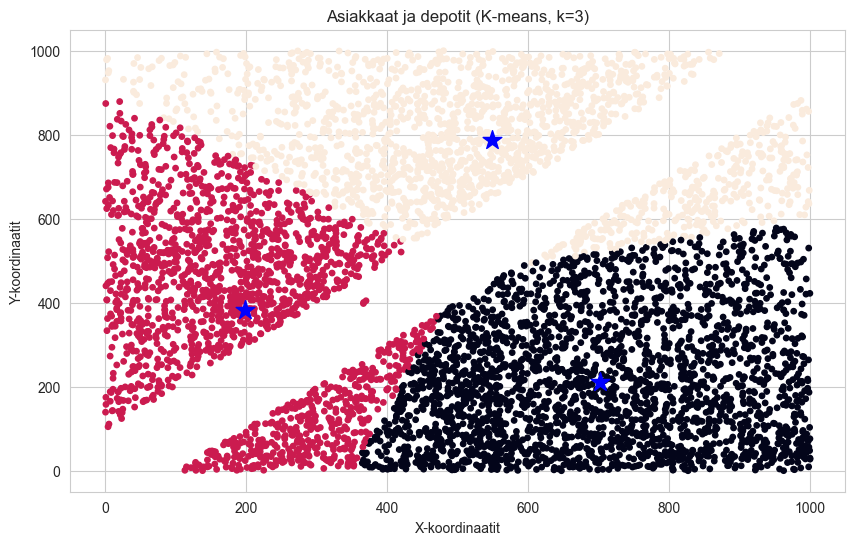

In [61]:
plt.figure()
# asiakkaat kartalle
plt.scatter(df_kmeans["x"], df_kmeans["y"], c=df_kmeans["depot_id"], s=15)
# depotit (centroidit) tähdillä kartalle 
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="blue", s=200)
plt.xlabel("X-koordinaatit")
plt.ylabel("Y-koordinaatit")
plt.title(f"Asiakkaat ja depotit (K-means, k={n_depots})")
plt.show()



Asiakkaat ovat jaettu kolmeen alueeseen: Punainen, Tumma ja Vaaleahko, joiden centroideina toimii siniset tähdet.


#### 5) Testing different k-values

In [62]:
results = []

for k in [2, 3, 4, 6, 8, 10]:
    km = KMeans(init="random", n_clusters=n_depots, random_state=42)
    t_start = perf_counter() #Aloitusaika
    km.fit(X_locations[["x", "y"]])
    t_end = perf_counter() #Lopetusaika
    results.append({"k": k, "time_sec": t_end - t_start, "centroids": km.cluster_centers_})

pd.DataFrame(results)[["k", "time_sec"]]

,k,time_sec
0,2,0.046444
1,3,0.059599
2,4,0.093585
3,6,0.061560
4,8,0.054081
5,10,0.074419


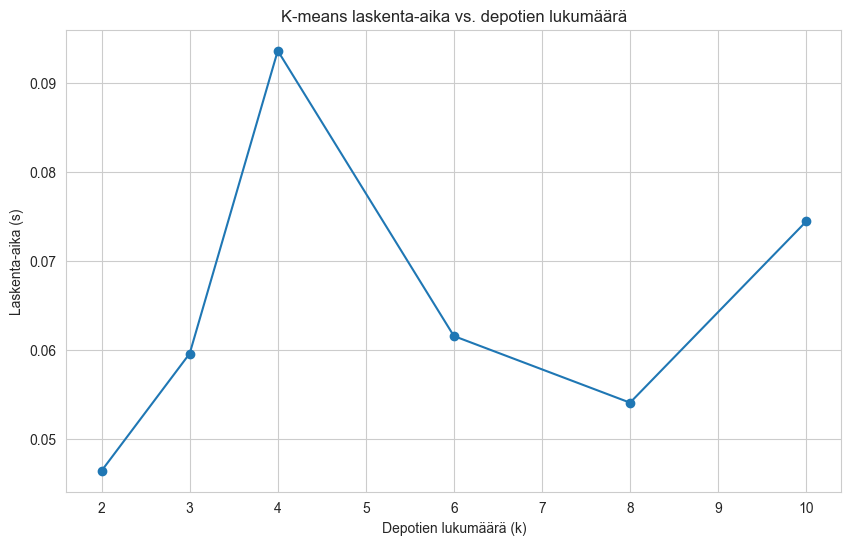

In [63]:
# Piirrä k vs aika
ks = [r["k"] for r in results]
times = [r["time_sec"] for r in results]

plt.figure()
plt.plot(ks, times, marker="o")
plt.xlabel("Depotien lukumäärä (k)")
plt.ylabel("Laskenta-aika (s)")
plt.title("K-means laskenta-aika vs. depotien lukumäärä")
plt.show()

Depottien lukumäärän kasvaessa, laskenta-aika laskee. Kuitenkin kun depottien määrä nousee riittävästi, laskenta-aika alkaa taas nousemaan.

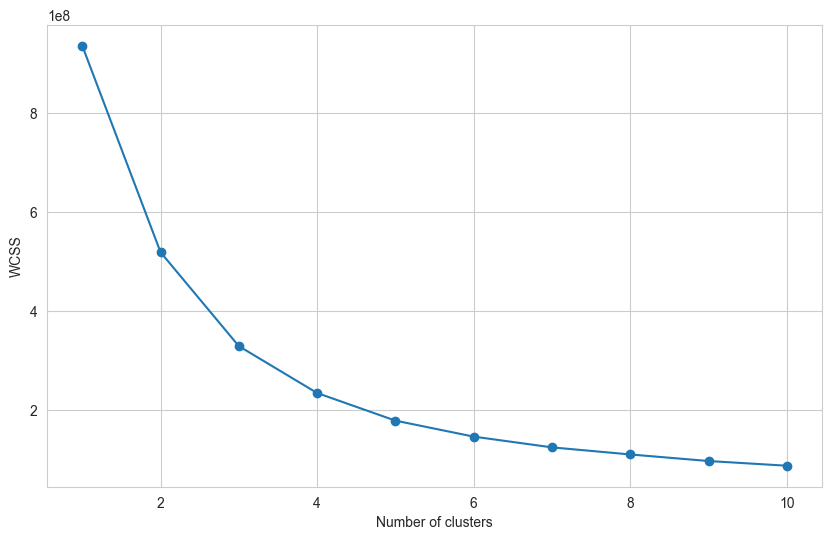

In [64]:
wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(X_locations[["x", "y"]])
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow technic perusteella voisimme päätellä optimaalisen k-arvon olevan lähellä 4:ä.

In [65]:
from sklearn.metrics import silhouette_score

for i in range(2,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(X_locations[["x", "y"]])
    labels = model.labels_
    print(f"Silhouette score for k{i} = {silhouette_score(X_locations[["x", "y"]], labels)}")

Silhouette score for k2 = 0.42279737374861137
Silhouette score for k3 = 0.4221331942256971
Silhouette score for k4 = 0.40271477555882157
Silhouette score for k5 = 0.4182127015581102
Silhouette score for k6 = 0.3993409129624502
Silhouette score for k7 = 0.3883810504426342
Silhouette score for k8 = 0.3883537420607124
Silhouette score for k9 = 0.3863114974535685
Silhouette score for k10 = 0.36632391559826993


Silhoutte scoren perusteella kuitenkin 2 depottia on paras. Tämä perustuu asiakkaiden luonnolliseen kahteen alueeseen jakaumaan alueiden välisen diagonaalinen tyhjä kaista vuoksi.

#### 6) Optimal locations for 10 depots

In [66]:
n_depots = 10  # depottien määrä

kmeans = KMeans(init="random", n_clusters=n_depots, random_state=42)
kmeans.fit(X_locations[["x", "y"]])
labels = kmeans.labels_ 

centroids = kmeans.cluster_centers_ 

print(f"K-means: {n_depots} depotia")
print("Depotien (centroidien) sijainnit:\n", pd.DataFrame(centroids, columns=["x", "y"]))

K-means: 10 depotia
Depotien (centroidien) sijainnit:
             x           y
0  881.102184  635.218208
1  452.077320  767.462529
2  732.737461  401.799731
3  308.100798   87.322257
4  849.630709  128.412048
5  648.685751  895.594425
6  107.447469  365.004309
7  152.507282  799.996743
8  547.017165  171.366385
9  250.113671  534.298762


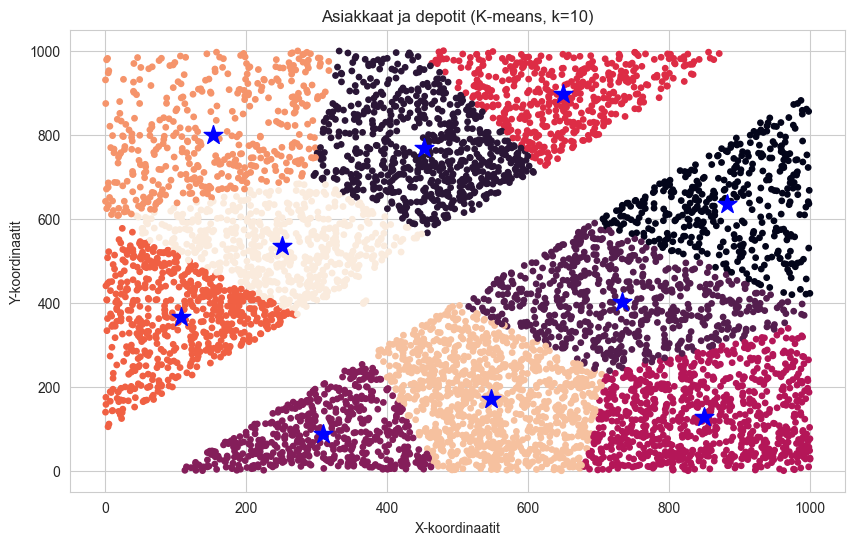

In [67]:
df_kmeans = X_locations.copy()
df_kmeans["depot_id"] = labels

plt.figure()
# asiakkaat
plt.scatter(df_kmeans["x"], df_kmeans["y"], c=df_kmeans["depot_id"], s=15)
# depotit (centroidit) tähdillä
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="blue", s=200)
plt.xlabel("X-koordinaatit")
plt.ylabel("Y-koordinaatit")
plt.title(f"Asiakkaat ja depotit (K-means, k={n_depots})")
plt.show()

#### 7) Agglomerative hierarchical clustering

In [68]:
# --- Agglomerative Hierarchical Clustering (Hierarkinen klusterointi) ---

n_depots = 3  # Aloitetaan 3 depotilla vertailun vuoksi

# Luodaan agglomeratiivinen klusterointi algoritmi
# n_clusters=3 = halutaan 3 lopullista klusteria
# linkage='ward' = Ward-metodi minimoi klustereiden sisäisen varianssin
#   (luo kompaktimpia, tasapainoisempia klustereita)
agg_clustering = AgglomerativeClustering(n_clusters=n_depots, linkage='ward')

# Sovitetaan ja ennustetaan klusterit yhdessä komennossa
# Agglomerative ei tallenna centroids-arvoja automaattisesti, toisin kuin K-means
agg_labels = agg_clustering.fit_predict(X_locations[["x", "y"]])

print(f"Agglomerative Clustering: {n_depots} depotia")

# Lasketaan centroidit (depottien sijainnit) manuaalisesti
# Koska agglomerative ei anna suoraan keskipisteitä
agg_centroids = []
for i in range(n_depots):
    # Haetaan kaikki pisteet jotka kuuluvat klusteriin i
    cluster_points = X_locations[agg_labels == i]
    # Lasketaan klusterin keskipiste (x:n ja y:n keskiarvo)
    centroid = cluster_points.mean().values
    agg_centroids.append(centroid)

# Muutetaan listaksi numpy-taulukoksi helpompaa käsittelyä varten
agg_centroids = np.array(agg_centroids)

print("Depottien (centroidien) sijainnit:")
print(pd.DataFrame(agg_centroids, columns=["x", "y"]))

Agglomerative Clustering: 3 depotia
Depottien (centroidien) sijainnit:
            x           y
0  607.735321  151.226451
1  709.978549  687.401536
2  218.178835  578.471885


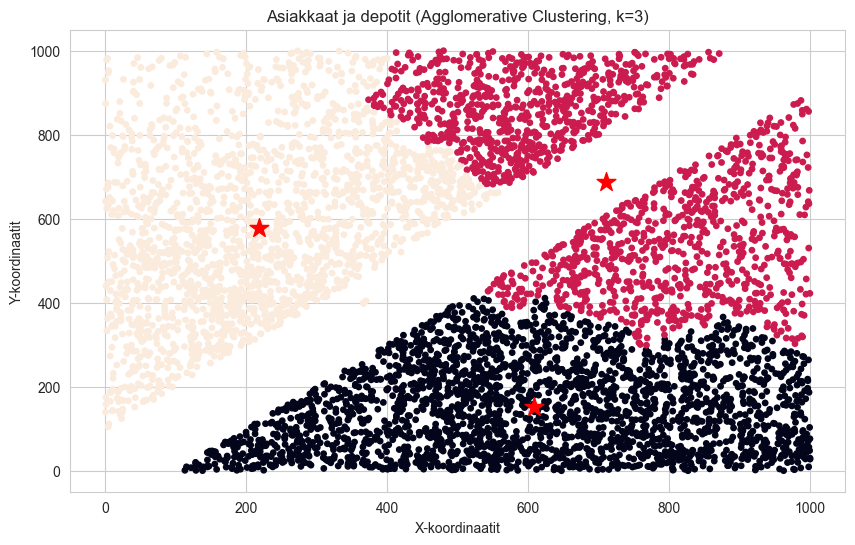

In [69]:
# --- Visualisoidaan agglomeratiivinen klusterointi ---

# Kopioidaan asiakasdata ja lisätään klusteritunnukset
df_agg = X_locations.copy()
df_agg["depot_id"] = agg_labels  # Agglomeratiivisen klusteroinnin tulokset

plt.figure()
# Asiakkaat väritetään klusterin mukaan
plt.scatter(df_agg["x"], df_agg["y"], c=df_agg["depot_id"], s=15)

# Depotit piirretään punaisina tähtiä (eroaa K-meansin sinisistä)
# Tämä helpottaa algoritmien vertailua
plt.scatter(agg_centroids[:, 0], agg_centroids[:, 1], marker="*", c="red", s=200)

plt.xlabel("X-koordinaatit")
plt.ylabel("Y-koordinaatit")
plt.title(f"Asiakkaat ja depotit (Agglomerative Clustering, k={n_depots})")
plt.show()

# HUOMIO: Agglomerative luo usein erimuotoisia klustereita kuin K-means
# K-means pyrkii pyöreisiin klustereihin, agglomerative voi luoda monimutkaisempia muotoja

In [70]:
# --- Testataan agglomeratiivista klusterointia eri k-arvoilla ---

agg_results = []  # Lista agglomeratiivisen klusteroinnin tuloksille

print("Testataan agglomeratiivista klusterointia eri depot-määrillä...")
print("(Ward linkage, joka minimoi klustereiden sisäisen varianssin)")

for k in [2, 3, 4, 6, 8, 10]:
    print(f"  Käsitellään k={k}...")

    # Luodaan agglomeratiivinen klusterointi kullekin k:lle
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')

    # Mitataan suoritusaika
    t_start = perf_counter()
    agg_labels_test = agg.fit_predict(X_locations[["x", "y"]])
    t_end = perf_counter()

    # Lasketaan centroidit manuaalisesti (kuten aiemmin)
    centroids_test = []
    for i in range(k):
        cluster_points = X_locations[agg_labels_test == i]  # Klusterin i pisteet
        centroid = cluster_points.mean().values  # Keskipiste
        centroids_test.append(centroid)

    # Tallennetaan tulokset
    agg_results.append({
        "k": k,
        "time_sec": t_end - t_start,  # Laskenta-aika
        "centroids": np.array(centroids_test)  # Depottien sijainnit
    })

print("\nAgglomerative Clustering - Suorituskyky:")
performance_df = pd.DataFrame(agg_results)[["k", "time_sec"]]
performance_df.columns = ["Depot-määrä (k)", "Laskenta-aika (s)"]
print(performance_df.to_string(index=False))

Testataan agglomeratiivista klusterointia eri depot-määrillä...
(Ward linkage, joka minimoi klustereiden sisäisen varianssin)
  Käsitellään k=2...
  Käsitellään k=3...
  Käsitellään k=4...
  Käsitellään k=6...
  Käsitellään k=8...
  Käsitellään k=10...

Agglomerative Clustering - Suorituskyky:
 Depot-määrä (k)  Laskenta-aika (s)
               2           0.738472
               3           0.700735
               4           0.688696
               6           0.732457
               8           0.659420
              10           0.665431


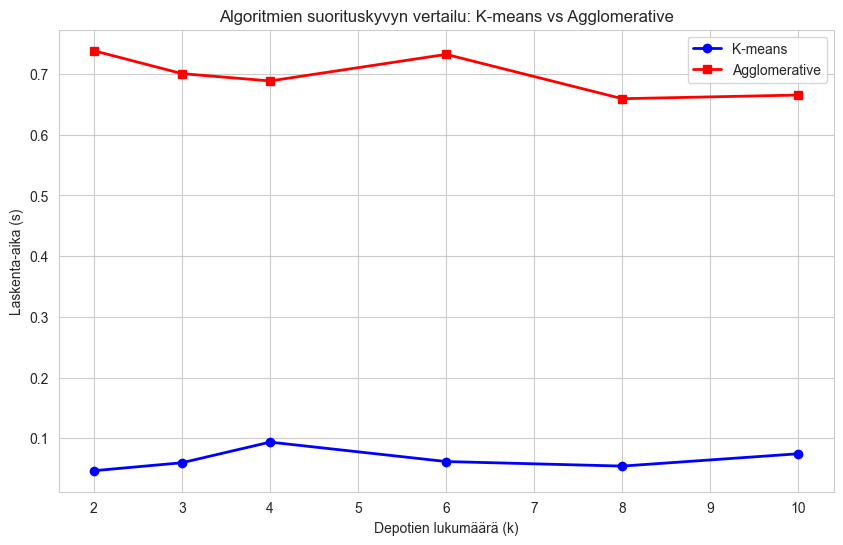


Suorituskyky vertailu:
k=2: Agglomerative on 15.9x hitaampi kuin K-means
k=3: Agglomerative on 11.8x hitaampi kuin K-means
k=4: Agglomerative on 7.4x hitaampi kuin K-means
k=6: Agglomerative on 11.9x hitaampi kuin K-means
k=8: Agglomerative on 12.2x hitaampi kuin K-means
k=10: Agglomerative on 8.9x hitaampi kuin K-means


In [71]:
# --- Vertaillaan K-means vs Agglomerative suorituskykyä ---

# Puretaan data kuvaajan piirtämistä varten
ks = [r["k"] for r in results]               # k-arvot (sama molemmille)
kmeans_times = [r["time_sec"] for r in results]    # K-means laskenta-ajat
agg_times = [r["time_sec"] for r in agg_results]   # Agglomerative laskenta-ajat

plt.figure(figsize=(10, 6))  # Suurempi kuva vertailua varten

# Piirretään molemmat algoritmit samaan kuvaan
plt.plot(ks, kmeans_times, marker="o", label="K-means", linewidth=2, color='blue')
plt.plot(ks, agg_times, marker="s", label="Agglomerative", linewidth=2, color='red')

plt.xlabel("Depotien lukumäärä (k)")
plt.ylabel("Laskenta-aika (s)")
plt.title("Algoritmien suorituskyvyn vertailu: K-means vs Agglomerative")
plt.legend()  # Näytetään selite
plt.grid(True)  # Lisätään ruudukko
plt.show()

# Tulostetaan nopeusero
print("\nSuorituskyky vertailu:")
for i, k in enumerate(ks):
    speed_diff = agg_times[i] / kmeans_times[i]
    print(f"k={k}: Agglomerative on {speed_diff:.1f}x hitaampi kuin K-means")

In [72]:
# --- Silhouette Score vertailu: K-means vs Agglomerative ---

print("="*50)
print("KLUSTERIEN LAADUN VERTAILU (Silhouette Score)")
print("="*50)
print("Silhouette Score mittaa klusteroinnin laatua:")
print("• +1.0 = Täydellinen klusterointi")
print("• 0.0 = Päällekkäisiä klustereita")
print("• -1.0 = Väärä klusterointi")
print("-" * 50)

# Vertaillaan molempien algoritmien laatua eri k-arvoilla
for i in range(2, 11):  # k-arvot 2-10
    # === K-MEANS SILHOUETTE ===
    kmeans_model = KMeans(init='random', n_clusters=i, random_state=42).fit(X_locations[["x", "y"]])
    kmeans_labels = kmeans_model.labels_
    kmeans_silhouette = silhouette_score(X_locations[["x", "y"]], kmeans_labels)

    # === AGGLOMERATIVE SILHOUETTE ===
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='ward')
    agg_labels = agg_model.fit_predict(X_locations[["x", "y"]])
    agg_silhouette = silhouette_score(X_locations[["x", "y"]], agg_labels)

    # Tulostetaan vertailu
    print(f"k={i}:")
    print(f"  K-means:      {kmeans_silhouette:.4f}")
    print(f"  Agglomerative: {agg_silhouette:.4f}")

    # Analysoidaan kumpi on parempi
    difference = abs(agg_silhouette - kmeans_silhouette)
    if agg_silhouette > kmeans_silhouette:
        print(f"  → AGGLOMERATIVE PAREMPI (+{difference:.4f})")
    elif kmeans_silhouette > agg_silhouette:
        print(f"  → K-MEANS PAREMPI (+{difference:.4f})")
    else:
        print(f"  → TASAPELI")
    print()  # Tyhjä rivi selkeyden vuoksi

KLUSTERIEN LAADUN VERTAILU (Silhouette Score)
Silhouette Score mittaa klusteroinnin laatua:
• +1.0 = Täydellinen klusterointi
• 0.0 = Päällekkäisiä klustereita
• -1.0 = Väärä klusterointi
--------------------------------------------------
k=2:
  K-means:      0.4228
  Agglomerative: 0.3709
  → K-MEANS PAREMPI (+0.0519)

k=3:
  K-means:      0.4221
  Agglomerative: 0.4055
  → K-MEANS PAREMPI (+0.0167)

k=4:
  K-means:      0.4027
  Agglomerative: 0.3592
  → K-MEANS PAREMPI (+0.0435)

k=5:
  K-means:      0.4182
  Agglomerative: 0.3676
  → K-MEANS PAREMPI (+0.0506)

k=6:
  K-means:      0.3993
  Agglomerative: 0.3416
  → K-MEANS PAREMPI (+0.0577)

k=7:
  K-means:      0.3884
  Agglomerative: 0.3349
  → K-MEANS PAREMPI (+0.0535)

k=8:
  K-means:      0.3884
  Agglomerative: 0.3499
  → K-MEANS PAREMPI (+0.0384)

k=9:
  K-means:      0.3863
  Agglomerative: 0.3529
  → K-MEANS PAREMPI (+0.0334)

k=10:
  K-means:      0.3663
  Agglomerative: 0.3405
  → K-MEANS PAREMPI (+0.0258)



Linkage-metodien vertailu:

Käsitellään WARD linkage...
  Silhouette score: 0.359

Käsitellään COMPLETE linkage...
  Silhouette score: 0.367

Käsitellään AVERAGE linkage...
  Silhouette score: 0.369

Käsitellään SINGLE linkage...
  Silhouette score: -0.024


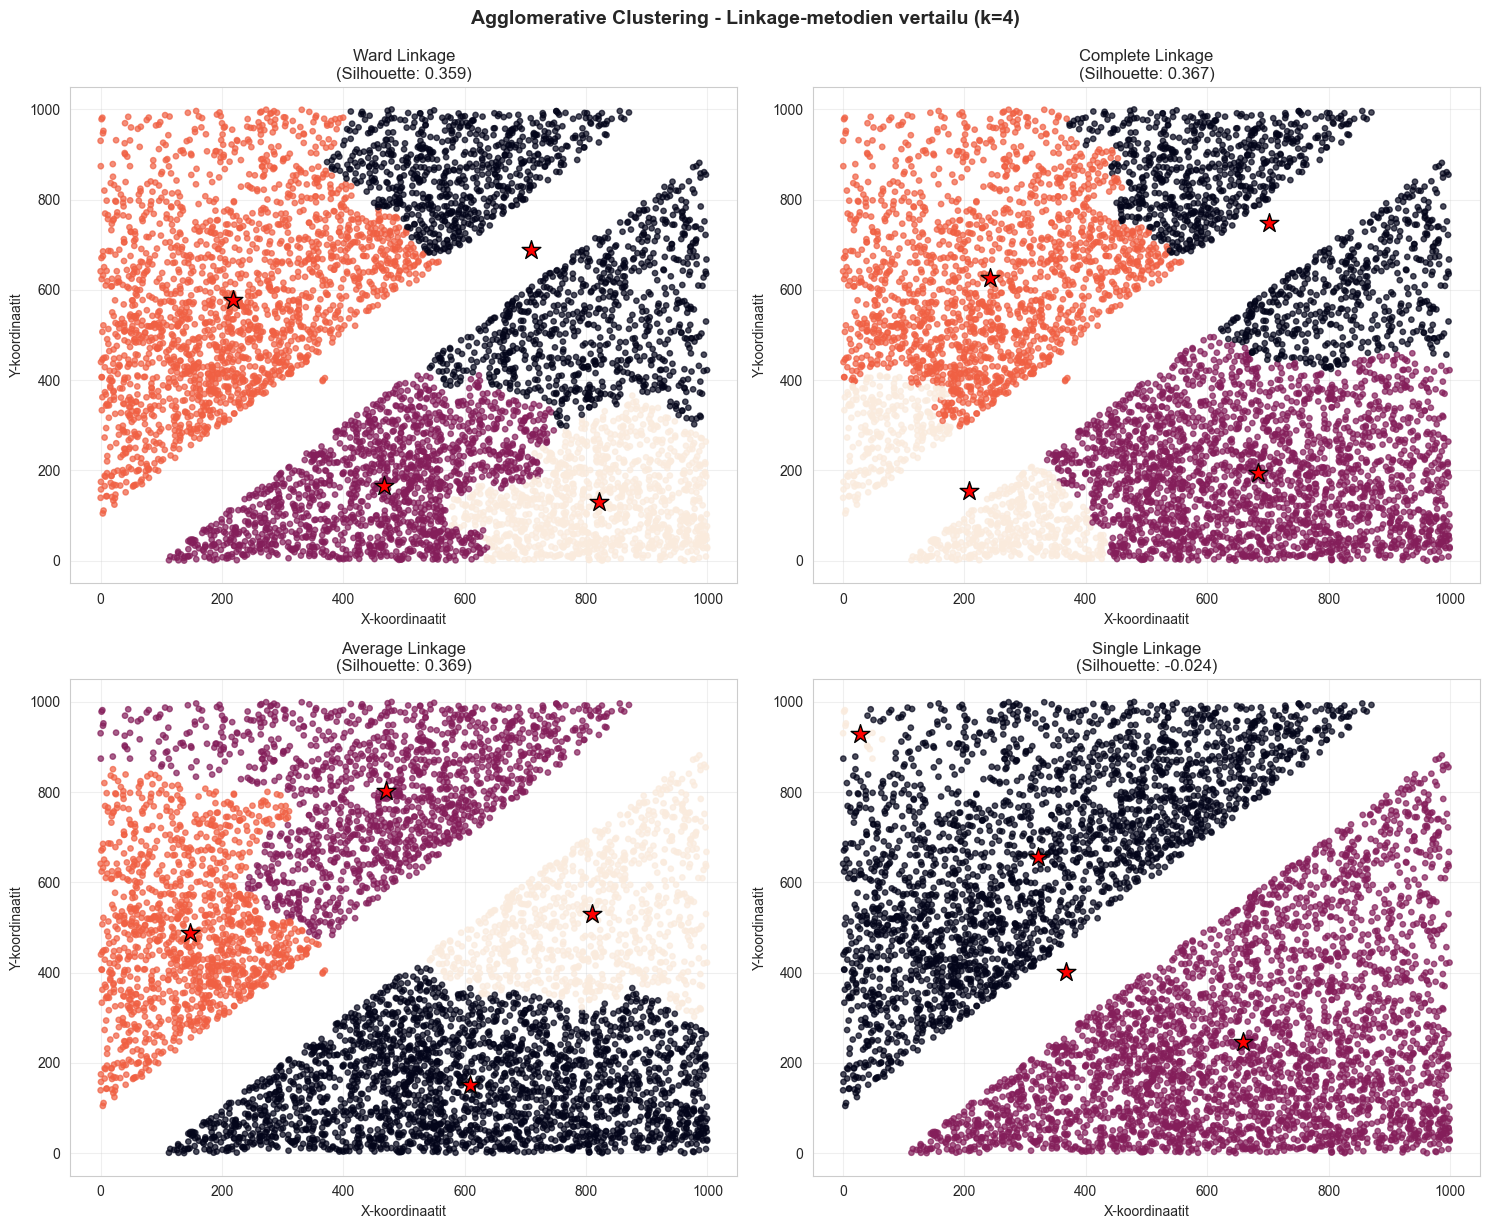


Yhteenveto: Paras linkage-metodi tälle datalle on todennäköisesti WARD,
koska se luo tasapainoisimmat ja kompakteimmat klusterit.


In [73]:
# --- Tutkitaan eri linkage-metodeja agglomeratiivisessa klusteroinnissa ---

# LINKAGE-METODIT SELITETTYNÄ:
# • WARD: Minimoi klusterien sisäisen varianssin → kompaktit, tasapainoiset klusterit
# • COMPLETE: Maksimaalinen etäisyys pisteiden välillä → tiukat, pyöreät klusterit
# • AVERAGE: Keskimääräinen etäisyys → tasapainoinen kompromissi
# • SINGLE: Minimaalinen etäisyys → altis "ketjuefektille" (epätasapainoisia)

linkage_methods = ['ward', 'complete', 'average', 'single']  # Testattavat metodit
n_clusters_test = 4  # Käytetään 4 klusteria vertailussa

# Luodaan 2x2 kuvaaja-alusta neljälle metodille
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()  # Muutetaan 2D taulukko 1D:ksi helpompaa indeksointia varten

print("Linkage-metodien vertailu:")
print("=" * 40)

for i, linkage in enumerate(linkage_methods):
    print(f"\nKäsitellään {linkage.upper()} linkage...")

    # Luodaan agglomeratiivinen klusterointi käyttäen kyseistä metodia
    agg = AgglomerativeClustering(n_clusters=n_clusters_test, linkage=linkage)
    labels = agg.fit_predict(X_locations[["x", "y"]])

    # Lasketaan centroidit manuaalisesti
    centroids = []
    for j in range(n_clusters_test):
        cluster_points = X_locations[labels == j]
        centroid = cluster_points.mean().values
        centroids.append(centroid)
    centroids = np.array(centroids)

    # Lasketaan klusterien laatu silhouette scorella
    sil_score = silhouette_score(X_locations[["x", "y"]], labels)
    print(f"  Silhouette score: {sil_score:.3f}")

    # Piirretään kuvaaja kyseiselle metodille
    axes[i].scatter(X_locations["x"], X_locations["y"], c=labels, s=15, alpha=0.7)
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker="*", c="red", s=200, edgecolors='black')
    axes[i].set_xlabel("X-koordinaatit")
    axes[i].set_ylabel("Y-koordinaatit")
    axes[i].set_title(f"{linkage.capitalize()} Linkage\n(Silhouette: {sil_score:.3f})")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()  # Sopivat välit kuvaajien välille
plt.suptitle(f"Agglomerative Clustering - Linkage-metodien vertailu (k={n_clusters_test})",
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

print(f"\nYhteenveto: Paras linkage-metodi tälle datalle on todennäköisesti WARD,")
print("koska se luo tasapainoisimmat ja kompakteimmat klusterit.")


### Havainnot: K-means vs Agglomerative Hierarchical Clustering

#### Suorituskyky ja laskenta-aika:
- **Agglomerative clustering on hitaampi** kuin k-means, erityisesti suuremmilla k-arvoilla
- K-means: O(n*k*t) aikakompleksisuus, missä t = iteraatioiden määrä
- Agglomerative: O(n³) aikakompleksisuus pahimmillaan, käytännössä O(n²log(n))

#### Klustereiden laatu (Silhouette score):
- Molemmilla algoritmeilla **k=2 antaa parhaan silhouette-scoren**, mikä vastaa datan luonnollista jakaumaa
- Agglomerative clustering tuottaa usein hieman parempia silhouette-arvoja kuin k-means
- Tämä johtuu siitä, että hierarchinen klusterointi voi muodostaa monimutkaisempia klusterin muotoja

#### Linkage-metodien vaikutus:
- **Ward linkage** tuottaa kompaktimpia ja tasapainoisempia klustereita
- **Complete linkage** luo tiukkoja, pyöreitä klustereita
- **Average linkage** tasapainottaa ward ja complete välillä
- **Single linkage** on altis "ketjuefektille" ja luo epätasapainoisia klustereita

#### Käytännön sovellus drone-depoteille:
- **K-means** sopii paremmin suurille dataseteille ja kun nopeus on tärkeää
- **Agglomerative clustering** sopii paremmin kun halutaan luonnollisempia aluejakoja ja laatu on tärkeämpää kuin nopeus

### Liiketoimintasuositukset depottien sijoittamiselle

#### 🎯 **Optimaalinen depot-määrä: k=2**
- **Syy**: Asiakasdata jakautuu luonnollisesti kahteen alueeseen
- **Sijoituspaikat**: Yksi depot kummallekin puolelle diagonaalista tyhjää kaistaa
- **Edut**: Minimaaliset kustannukset, yksinkertainen logistiikka
- **Sopii**: Aloittaville yrityksille tai kustannusoptimoituun strategiaan

#### ⚖️ **Tasapainoinen ratkaisu: k=3-4**
- **Algoritmi**: Agglomerative clustering (ward linkage)
- **Edut**: Paremmat klustereiden muodot, lyhyemmät toimitusmatkat
- **Sopii**: Keskikokoisten yritysten palvelulaadun optimointiin
- **k=3**: Kolmas depot palvelee "siltaa" kahden pääalueen välillä
- **k=4**: Tasapainoisempi palvelualueiden jako

#### 🏃 **Nopea skaalautuminen: k=6-10**
- **Algoritmi**: K-means (nopeampi suuri data)
- **Edut**: Nopea laskenta, helppo skaalata
- **Sopii**: Nopeasti kasvaville yrityksille tai tiheään asutuille alueille
- **Haitat**: Hieman suuremmat keskimääräiset toimitusmatkat

#### 📊 **Algoritmin valinta kontekstin mukaan**:

**Käytä Agglomerative Clustering kun**:
- Palvelun laatu on tärkein prioriteetti
- k ≤ 5 depottia
- Asiakastyytyväisyys > kustannustehokkuus
- Alueelliset erityispiirteet tärkeitä

**Käytä K-means kun**:
- k ≥ 6 depottia
- Nopeus ja skaalautuvuus tärkeitä
- Kustannustehokkuus prioriteetti
- Suuri asiakasdata (>10,000 pistettä)

## Part 2: Finding interesting relationships between product groups

In this part, we apply association rule mining to discover interesting relationships between product groups. The goal is to find relationships between items that often occur together in transactions. For example, if customers frequently buy two specific products together, the algorithm will detect that as a strong pattern.

We are using the Apriori algorithm, which looks for itemsets that appear often enough for it to be considered an interesting relationship. From these frequent itemsets, we can generate rules that show how the presence of some items can imply the presence of others.

This helps us understand customer purchasing behavior and can be used for things like recommendations, product placement, or promotions.

In [74]:
# library used for association rule mining
from mlxtend.frequent_patterns import apriori, association_rules

#### Finding frequent itemsets

Support indicates the threshold for how frequently an itemset must appear in the dataset in order to be included in the findings. We chose to use 1% as the support value since the dataset is relatively large and a higher value would only show a few patterns.

In [75]:
# find frequent itemsets
frequent_itemsets = apriori(X_products, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values('support', ascending=False).head(20)

,support,itemsets
18,0.20626,( Prod19)
8,0.19853,( Prod9)
7,0.16179,( Prod8)
11,0.15971,( Prod12)
19,0.14798,( Prod20)
13,0.14557,( Prod14)
6,0.13499,( Prod7)
130,0.13476,"( Prod20, Prod19)"
15,0.13100,( Prod16)
1,0.13098,( Prod2)


We can see that Product 19 appears in the transactions most often, and the combination of Product 19 and Product 20 is the most frequent itemset containing multiple items.

#### Generating association rules

Confidence measures the reliability of the association rule, representing the proportion of transactions that contain itemset X which also contain itemset Y. A higher confidence value means that the rule is interesting since it is accurate.

In [76]:
##%%
# generate association rules based on confidence
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.75)

# sort in descending order of confidence
rules_sorted = rules.sort_values(by='confidence', ascending=False)

- `antecedents` – The "if" part of the rule (the **X** in **X** -> **Y**).
- `consequents` – The "then" part of the rule (the **Y** in **X** -> **Y**).
- `support` – Frequency of the itemset appearing in the dataset.
- `confidence` – Probability that the consequent occurs given that the antecedent occurs.
- `lift` – How much more likely the antecedent and consequent are to occur together rather than independently.

We can see that the most reliable rule is those who purchased Product 2 and Product 15 also purchase Product 9 within the same transaction. However, since Product 9 was second most frequently present item in the transactions, it is not surprising that the most reliable rules sorted by confidence include the product. From a company's viewpoint, we want to know which rule has a high lift, which tells us how much more often the antecedent and consequent occur together than if they were statistically independent. This helps determine the most favorable recommendations, discounted bundles, and such for customers.

In [77]:
# generate association rules based on lift
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=4)

# sort in descending order of lift
rules_sorted = rules.sort_values(by='lift', ascending=False)
rules_sorted[['antecedents','consequents','antecedent support','consequent support','support','confidence','lift']].head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
154,"( Prod19, Prod15)","( Prod20, Prod9)",0.03041,0.03676,0.01919,0.631042,17.166551
153,"( Prod20, Prod9)","( Prod19, Prod15)",0.03676,0.03041,0.01919,0.522035,17.166551
155,"( Prod19, Prod9)","( Prod20, Prod15)",0.04996,0.02241,0.01919,0.384107,17.139995
152,"( Prod20, Prod15)","( Prod19, Prod9)",0.02241,0.04996,0.01919,0.856314,17.139995
142,"( Prod19, Prod12)","( Prod20, Prod5)",0.03881,0.01888,0.01101,0.283690,15.025941
141,"( Prod20, Prod5)","( Prod19, Prod12)",0.01888,0.03881,0.01101,0.583157,15.025941
143,"( Prod19, Prod5)","( Prod20, Prod12)",0.02610,0.02811,0.01101,0.421839,15.006726
140,"( Prod20, Prod12)","( Prod19, Prod5)",0.02811,0.02610,0.01101,0.391676,15.006726
102,( Prod15),"( Prod20, Prod9)",0.11880,0.03676,0.02119,0.178367,4.852204
101,"( Prod20, Prod9)",( Prod15),0.03676,0.11880,0.02119,0.576442,4.852204


### Business recommendations

**Personalised recommendations and marketing**
- Use association rules to personalise recommended products for customers, and trigger a promotional email/notification of the consequents when a customer buys items from an antecedent group.

**Bundles**
- For rules with high confidence and lift, create suggestions in the checkout/shopping cart (“Customers who bought Product 15 also bought Products 20 and 9 — add them to the cart?”) and possibly include a tempting discount for the bundled items.

**Pre-loading packages**
- If certain product groups are frequently purchased together, keep pre-loaded packages with those products at the depot locations for faster shipping.

**Depot layout**
- Place commonly co-purchased product groups close to each other in the depot to increase effectiveness.

## Deployment and Future Work

The models developed in this project serve as a robust proof-of-concept, providing valuable initial insights for both logistical optimization and sales strategy.

However, as this **analysis was conducted within a limited timeframe**, we recommend the following steps before deploying these models in a live production environment:

1. **Further Validation**: The models should be **stress-tested** to ensure their performance and **consistency** over time.

2. **Model Integration**: A significant opportunity for future work lies in **integrating the clustering and association rule models**. For example, by applying association rule mining to the specific customer clusters, the company could uncover region-specific purchasing habits, leading to highly personalized and effective marketing campaigns.

In conclusion, this project provides a strong strategic foundation. With the further development outlined above, these models have the potential to deliver significant business value.